# Week 5: Recurrent neural networks

Text, speech, weather, sensor output and video are but a few examples of the many types of data that is inherently sequential. So how does one predict the next word in a sentence, future temperatures or missing video frames? Using **recurrent neural networks** (RNNs)!

In [29]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import random
import sys
import io
import os
import datetime
from bs4 import BeautifulSoup
import requests as rq
from tensorflow.keras.callbacks import LambdaCallback
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.optimizers import RMSprop
from tensorflow import keras
from collections import Counter

## Exercises

#### Modeling text

Text prediction is a good place to start when learning about RNNs, because most of us humans have a pretty well
optimized inner model for text prediction ourselves. We can, therefore, easily assess the performance of a neural
network in executing this task.

Below is some code that loads the screenplay for Tarantino's 1994 film 'Pulp Fiction'. I recommend reading through the
first 20 lines or so to get a feeling for the language and style used (and enjoy probably the best written screenplay
in the history of film).

In [30]:
response = rq.get("https://imsdb.com/scripts/Pulp-Fiction.html")
text = BeautifulSoup(response.content, "html.parser").getText()
text = text[600:305110]
print(text[0:4000])



                                      "PULP FICTION"

                                            By

                             Quentin Tarantino & Roger Avary

                

               PULP [pulp] n.

               1. A soft, moist, shapeless mass or matter.

               2. A magazine or book containing lurid subject matter and 
               being characteristically printed on rough, unfinished paper.

               American Heritage Dictionary: New College Edition

               INT. COFFEE SHOP  MORNING

               A normal Denny's, Spires-like coffee shop in Los Angeles. 
               It's about 9:00 in the morning. While the place isn't jammed, 
               there's a healthy number of people drinking coffee, munching 
               on bacon and eating eggs.

               Two of these people are a YOUNG MAN and a YOUNG WOMAN. The 
               Young Man has a slight working-class English accent and, 
               like his fellow countryman, smo

> **Ex. 5.1.1:** What is the most used symbol in this screenplay and what accuracy would a model constantly predicting this symbol obtain? In other words, what is the "baseline accuracy"?

In [31]:
mycount = Counter(list(text))
total_length = len(text)
#print(total_length)
#print(mycount)
most_common_char, most_common_count = mycount.most_common(1)[0]
percentage = (most_common_count / total_length) * 100

print(f"The most common character is '{most_common_char}' with a percentage of {percentage:.2f}%")

The most common character is ' ' with a percentage of 54.11%


As we can see above, the most common character is the space character with over 50% of all characters being spaces in the text. this means that the likelyhood of any next character to be a space is 54.11% and so if a model just predicted the space character it would reach an accuracy of 54.11%. This is our baseline accuracy and we can expect to see the model quickly learn that spaces are easy wins and it will likely start by predicting a lot of spaces. If we improve significantly above this accuracy we know that the model has learned to predict more than just space characters and is a better model. 

I have adapted some code for text generation from [this Keras example](https://keras.io/examples/generative/lstm_character_level_text_generation/), and inserted questions in the code (look for `Q:`) for you to answer in the exercise below.

The code fits an LSTM recurrent neural network model to the `text` variable (the Pulp Fiction manuscript). Execute it and see it run. It fits over 100 epochs and took about 10 minutes on my computer.

In [92]:
# Q1: What is the purpose of this block? When is `char_indices` used? What about `indices_char`?
chars = sorted(list(set(text)))
char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))
#print(set(text))
#print(list(set(text)))
#print(chars)
#print("\n\n")
#print(char_indices)
#print(indices_char)

1: We first organize the characters in the text by getting the unique values using set, then casting that as a list and sorting that list by ascii value which organizes the list. Then we create two dictionaries with the sorted list, char_indices which is a dictionary where the keys are the characters and the values are the integers for their order in the sorted list and then indices_char which is a dictionary where the keys are the integers relating to the position of each character and the values being the characters themselves. They both contain basically the same information but with the keys and values reversed. These will be used throughout the code to either get the index of a character (char_indices) or to get the character at a certain index (indecies_char). For example, later on when we use the 83x1 one-hot-encoded vectors, we can check what an index represents by using indecies_char or set a 1 at a particular index for a certain character using char_indicies. 

In [93]:
# Q2: What is the purpose of this block? What does the `seqlen` and `step` parameters do?
seqlen = 40
step = seqlen
sentences = []
for i in range(0, len(text) - seqlen - 1, step):
    sentences.append(text[i: i + seqlen + 1])
#print(len(sentences))
#print(sentences[3])
#print(sentences[4])

2: This block divides the whole text in sentences of 40 characters. It loops through the whole text, takes 40 characters at a time and then puts them into an array of sentences. This makes around 7600 sentences for the entire script. seqlen sets the number of characters in a sentence and step makes the loop jump by 40 each time so that we dont produce sentences that overlap each other. Each sentence contains a unique sequence starting at 1 character past the last character of the previous sentence.

In [94]:
# Q3: What about this block? What is `x` and what is `y`? Why do they have this dimensionality?
x = np.zeros((len(sentences), seqlen, len(chars)), dtype=bool)
y = np.zeros((len(sentences), seqlen, len(chars)), dtype=bool)
for i, sentence in enumerate(sentences):
    # Q3a: What happens in this loop?
    for t, (char_in, char_out) in enumerate(zip(sentence[:-1], sentence[1:])):
        x[i, t, char_indices[char_in]] = 1
        y[i, t, char_indices[char_out]] = 1
#print(len(sentences), seqlen, len(chars))
#print(i,t)

3: x and y create a 3D array of boolean arrays. the dimensions of these arrays are first the how many sentences we have in the sentences array (7612), then the sentence length (40), and the the number of possible characters (83). We have this dimensionality because it creates the structure for one hot encoded lists for each character possibility. we have and x and y so that we can have an input and ouput to train the model. We did a drawing shown below to help our understand and help prove our understanding. We drew one 3D array (either x or y) where we can consider each sentence as a slice of the cube and then each sentence has 40 characters which are the columns of the slice. Now for each column we have 83x1 vector that represents the one-hot encoding for a particular character. We will use the dictionaries from earlier to help get and set these vecotrs.

3a: in this loop, we have already selected a particular sentence to look at. we then create the char_in which is the sentence except for the last character which will be used as the inputs and then char_out which is the sentence except for the first character which will be used as the output. Then we select the i'th sentence in x, and select the t'th timestep in the sentence and then selecting the character to encode as hot by putting the value of that vector at the character position to 1. In our drawing below we can see this how this loop goes through each timestep and encodes the index of the character in that sentence's position to 1. Say we have sentence 1 and timestep 2 where the sentence 1 is 'hello.' this means our i is 0 and our t is 1 (for the second timestep). this links the 'e' as the input character to the 'l' as the output character. we then set the true values in our x and y arrays for those corresponding indexes which in our photo would be slice 1, column 2 and then the corresponding 1s in the 83x1 vector of characters. We search for the 'e' charcter index and set that index to 1 in x. we then do the same in the y array and set the 'l' index to 1. 


Now we have our data built up in vector form to train the model with.

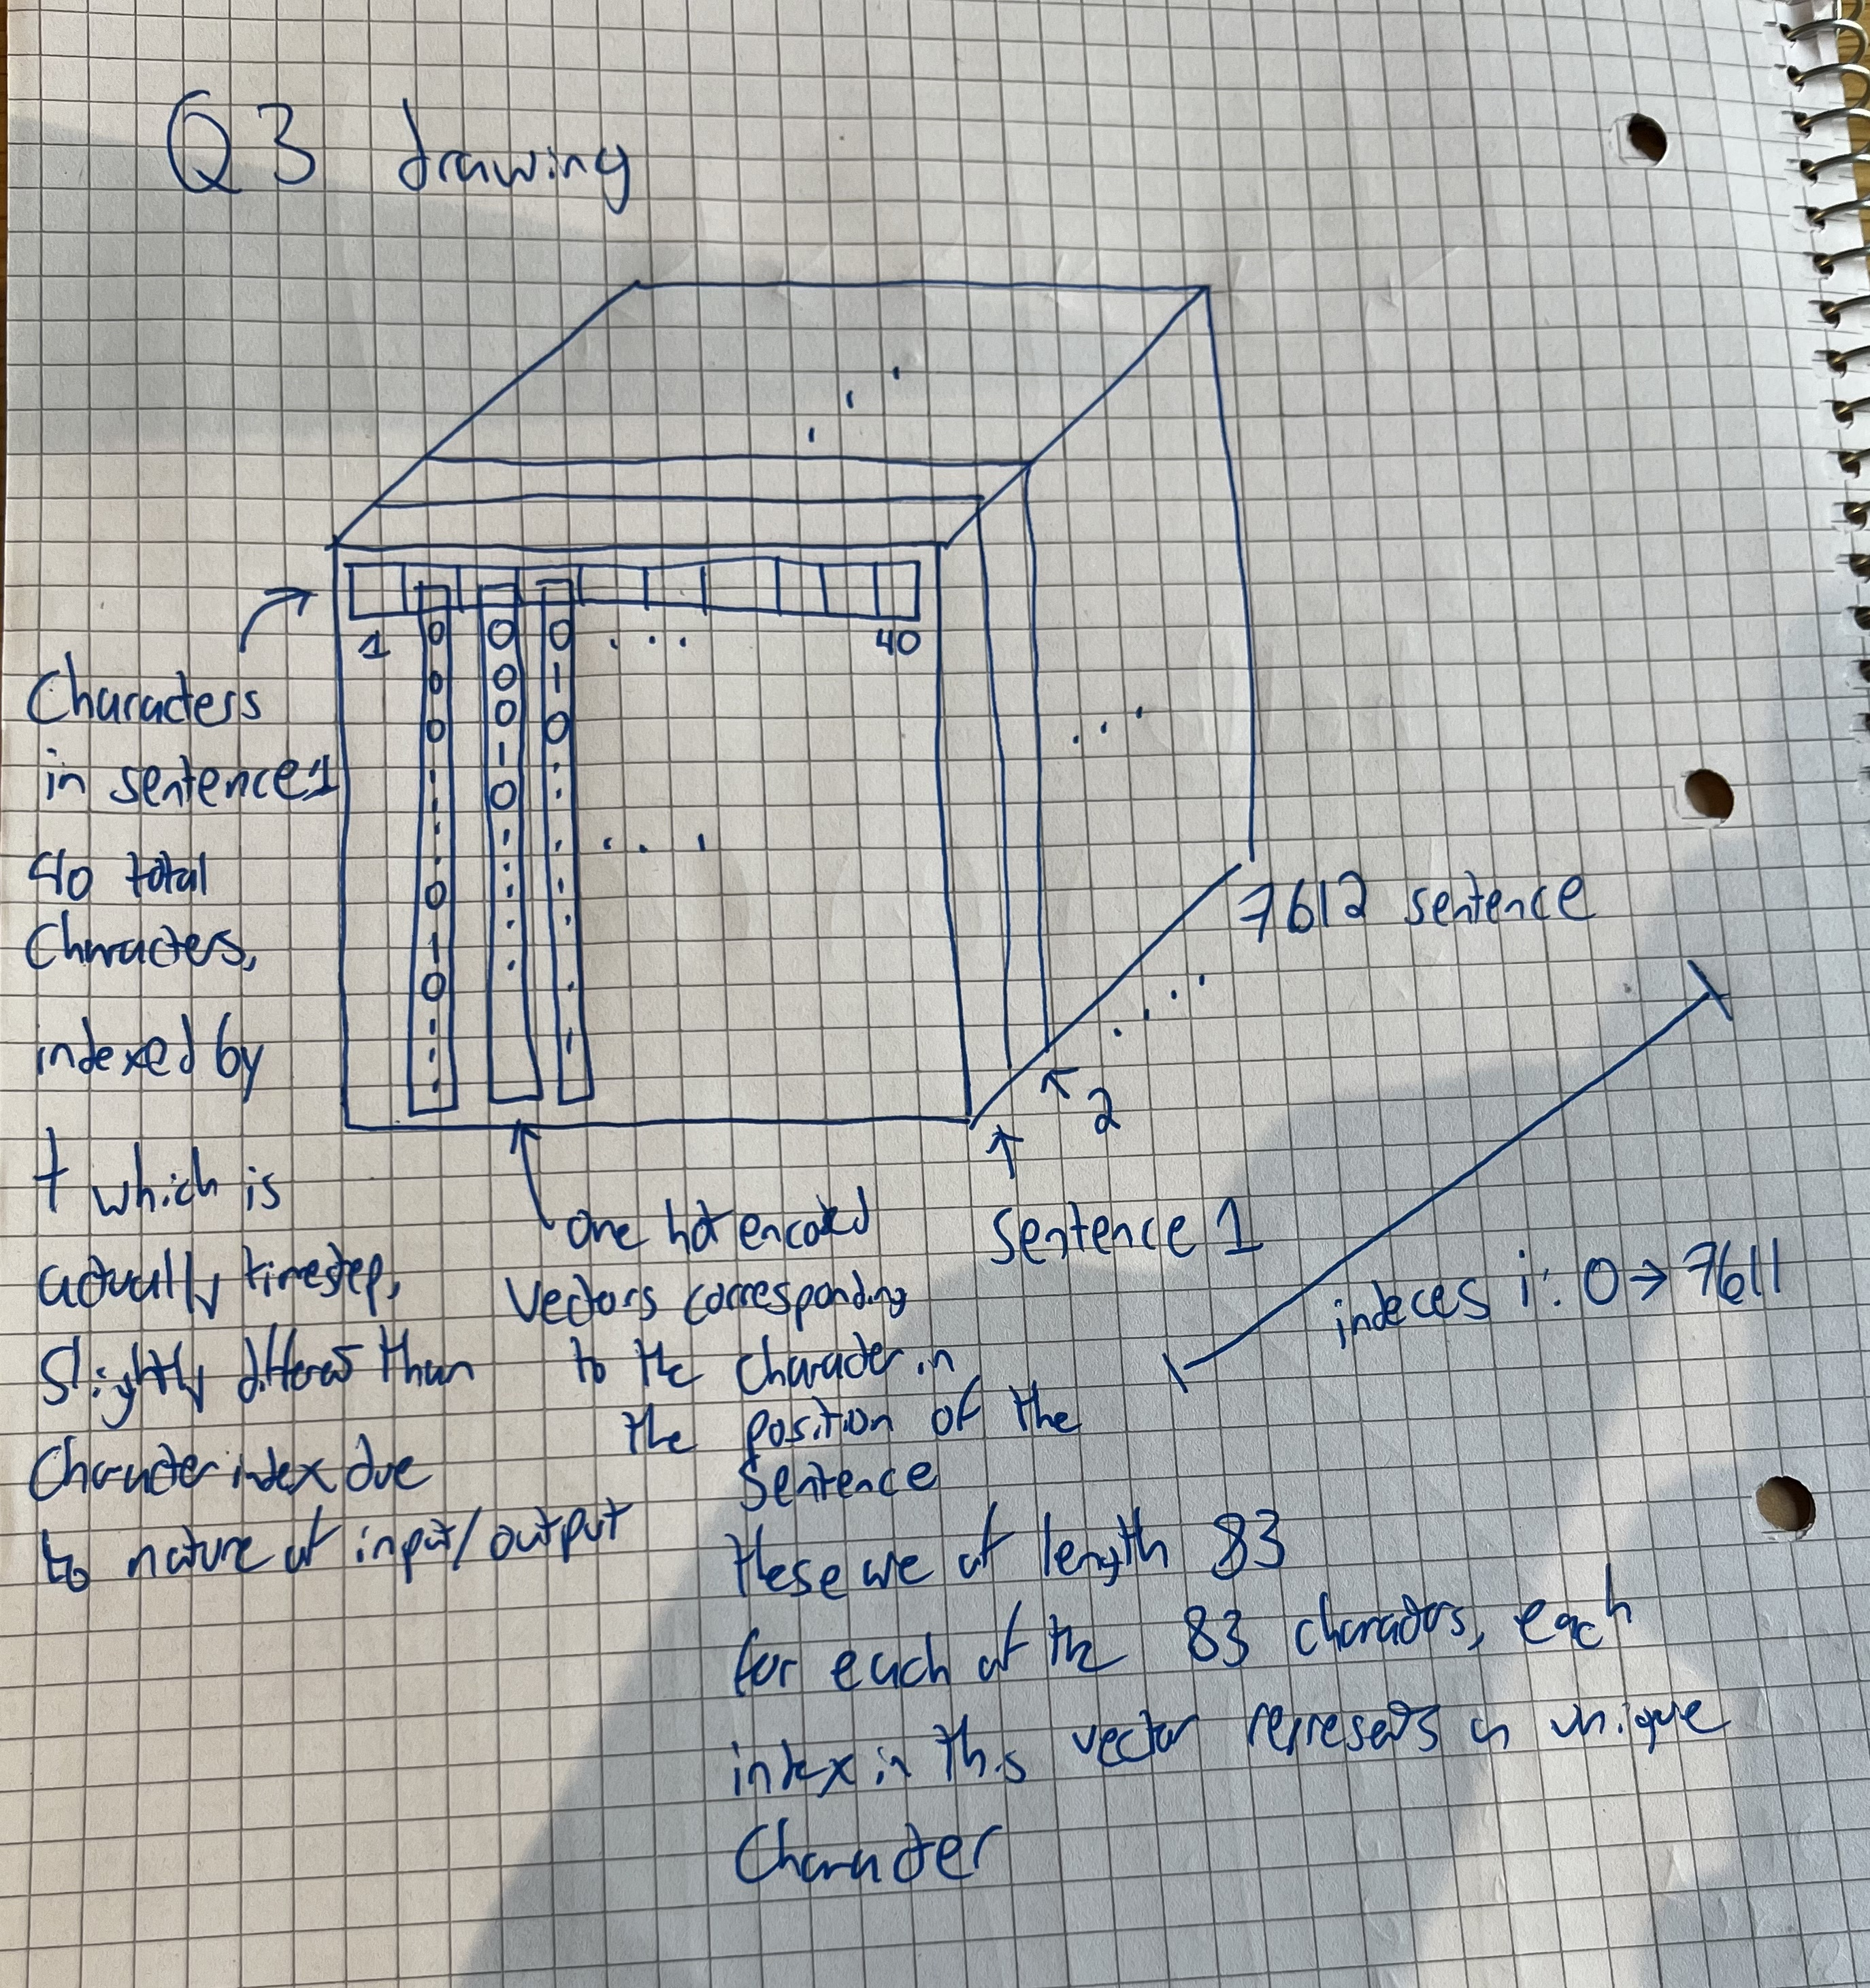

In [35]:
# Q4: Here we build the model. What does the `return_sequences` argument do? Why the dense layer at the end?
model = Sequential()
model.add(LSTM(128, input_shape=(seqlen, len(chars)), return_sequences=True))
model.add(Dense(len(chars), activation='softmax'))

model.compile(
    loss='categorical_crossentropy',
    optimizer=RMSprop(learning_rate=0.01),
    metrics=['categorical_crossentropy', 'accuracy']
)

def sample(preds, temperature=1.0):
    """Helper function to sample an index from a probability array."""
    preds = np.asarray(preds).astype('float64')
    preds = np.exp(np.log(preds) / temperature)  # softmax
    preds = preds / np.sum(preds)                #
    probas = np.random.multinomial(1, preds, 1)  # sample index
    return np.argmax(probas)                     #


def on_epoch_end(epoch, _):
    """Call backs are functions invoked at end of each epoch.
       This one prints generated text at the end of every 5th
       epoch."""
    if epoch%5 == 0:
        print()
        print('----- Generating text after Epoch: %d' % epoch)

        start_index = random.randint(0, len(text) - seqlen - 1)

        # Q5: What does temperature do?
        for temperature in [0.2, 0.5, 1.0]:
            print('----- temperature:', temperature)

            generated = ''
            sentence = text[start_index: start_index + seqlen]
            generated += sentence
            print('----- Generating with seed: "' + sentence + '"')
            sys.stdout.write(generated)

            for i in range(400):
                x_pred = np.zeros((1, seqlen, len(chars)))
                for t, char in enumerate(sentence):
                    x_pred[0, t, char_indices[char]] = 1. 

                # Q6: What is the dimensionality of `preds`? Why do we input `preds[0, -1]` to the `sample` function?
                preds = model.predict(x_pred, verbose=0)
                #print(len(preds[0][0]))
                next_index = sample(preds[0, -1], temperature)
                next_char = indices_char[next_index]

                sentence = sentence[1:] + next_char

                sys.stdout.write(next_char)
                sys.stdout.flush()
            print()

print_callback = LambdaCallback(on_epoch_end=on_epoch_end)

Q4: return_sequences tells the model whether to return just the last hidden layer character or the entire series of hidden layer characters from each time step. We need it to be true in this case because we want the model to read out the full output sentence not just a single character and thus we need the full output sequence. The dense layer is needed so that each of the possible output characters is fully connected to the model. It makes the output a softmax probability distribution for each of the possible character outputs which is needed so that the model can actually predict a single character. This also helps solve the dimensionality issues that would come up if we tried to read the output without a fully connected layer. 

Q5: The temperature dial changes how we account for the softmaxing distribution of probabilites and how the model outputs a single probability character. This is how we understood what is happening: if we think of log(x)/t, where t is a fraction, 0.2, 0.5, or 1, we can thing of them instead as 5log(x), 2log(x), and log(x) which is also log(x^5), log(x^2), and log(x). This in essence takes the ouput probability predictions (x) for the last character and increases each of the individual character probabilites exponentially. Then we normalize the probabilities by dividing them each by their sum. The effect this has is making slight differences in probability much greater when the temperature is low (high exponent) and keeps them them similar differences when the temp is high (close to 1 exponent). now at the last line, where we do the random multinomal prediction, we are basically rolling a weighted die with the probabilites of the 86 characters. so, if the probabilites are much more extremely separated (as is the case for t=0.2) we end up with the most likely character almost all of the time. However, when the probabilities are much closer together as with the t=1 case, we are more likely to chose a character that is not the highest probability output from the model and thus our output becomes 'more random' because it is more likely to not chose the most likely character. Below I attached a picture of a sample case where we tried this to gain an understanding for how it works. (We didn't realize this is done by the code just below this lol) In our sample, we have a 4x1 instead of 83x1 vector for the characters 'h', 'e', 'l', and 'o' with predicted probabilities of 0.1, 0.3, 0.2 and 0.25 respectively. this is then ^5, squared, and kept the same based on the temperature. then below that they are normalized. We can see that for low temp, the probabilites get much more spread out, we are 65% likely to chose 'e' whereas in the high temp we are only 35% likely to chose 'e' and almost just as likely to instead chose 'o.' In the model we can see that when we have a low temp the model almost always makes the most likely choice and in the high temp it occasionally makes a different choice. 

Q6: preds is an ouput prediction array for one input sentence to one output sentence it is 1x40x83 for the one hot encoded characters for each of the character positions in that one sentence. it is the output predictions for the model for a single sentence. when we get preds[0] we now have the 40x83 2D array and then we get the last item of that 2D array which corresponds to a 83x1 vector that represents the softmax probabilities for the characters in the last position. this makes sense because we then use this next_index and get the next_char from the indices_char dictionary position for that character. this is then inputted into the sample function to go through the process described above with temp. We want an 83x1 vector for this process to correctly apply the temperature and softmax. 

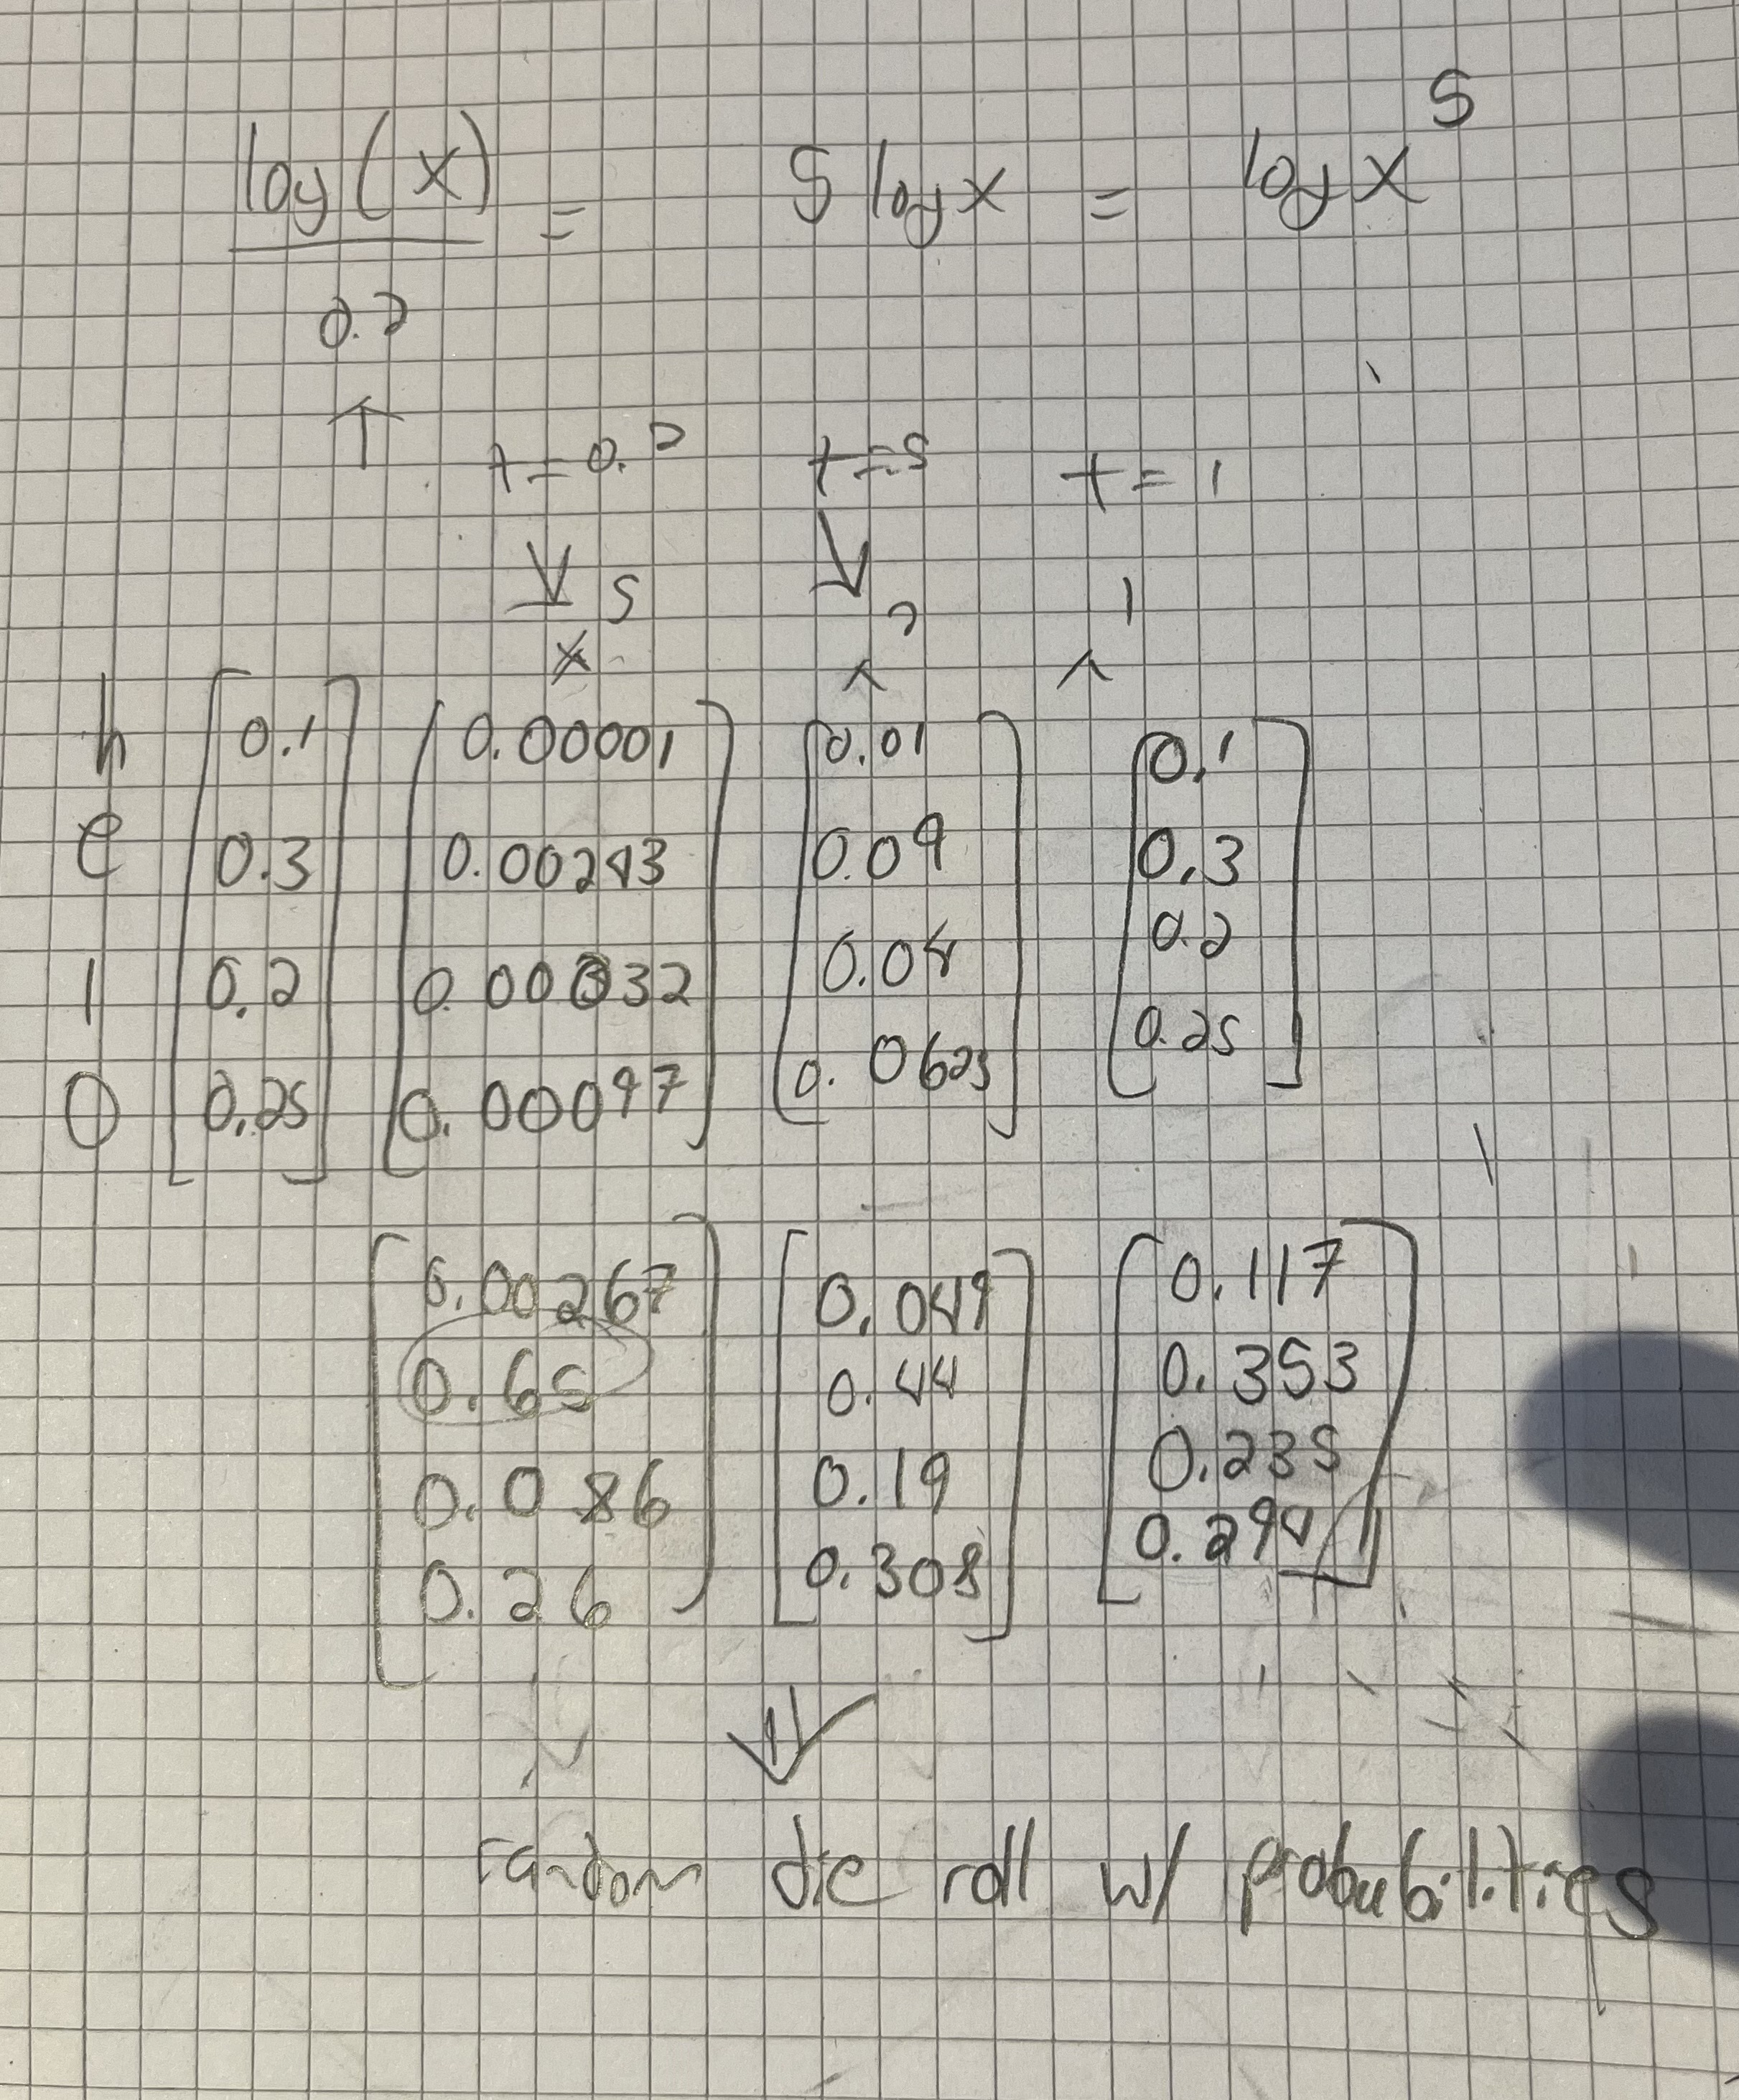

> **Ex. 5.1.2**: Start training the network (takes ~15 minutes on my computer) and save the progress in the variable `history` if you wish to plot the training process later. While it's running move on to the next question.

In [36]:
history = model.fit(x, y,
          batch_size=100,
          epochs=100,
          callbacks=[print_callback])

Epoch 1/100
76/77 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.4862 - categorical_crossentropy: 2.6253 - loss: 2.6253
----- Generating text after Epoch: 0
----- temperature: 0.2
----- Generating with seed: "       The Wolf smiles.

             "
       The Wolf smiles.

                                                                                                                                                                                                                                                                                                                                                                                                                             
----- temperature: 0.5
----- Generating with seed: "       The Wolf smiles.

             "
       The Wolf smiles.

                                                                                                                                                                                                  

> **Ex. 5.1.3**: Answer the questions in the code above (look for code comments starting with `Q:`).

Before proceeding to **Ex. 5.1.4** have a look at `sample` function. It's purpose is to draw samples according to a discrete probability distribution. Let's say that we have the possible outcomes **"h"**, **"e"**, **"l"** and **"o"**, and a probability distribution vector (as outputted by a neural network for example) $p = [0.20,\, 0.08,\, 0.65,\, 0.07]$, as visualized below:

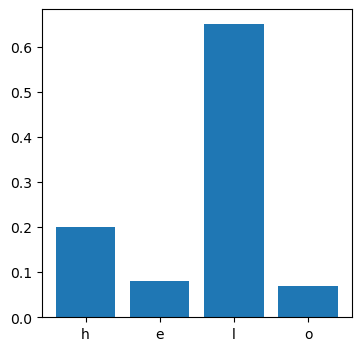

In [37]:
p = [0.20, 0.08, 0.65, 0.07] 
plt.figure(figsize = [4,4]); plt.bar(['h','e','l','o'],p);

Sampling with `temperature = 1` draws samples exactly according to `p`, but what does sampling with small values of `temperature` do? Try different values of `temp2` below to get a sense for it.

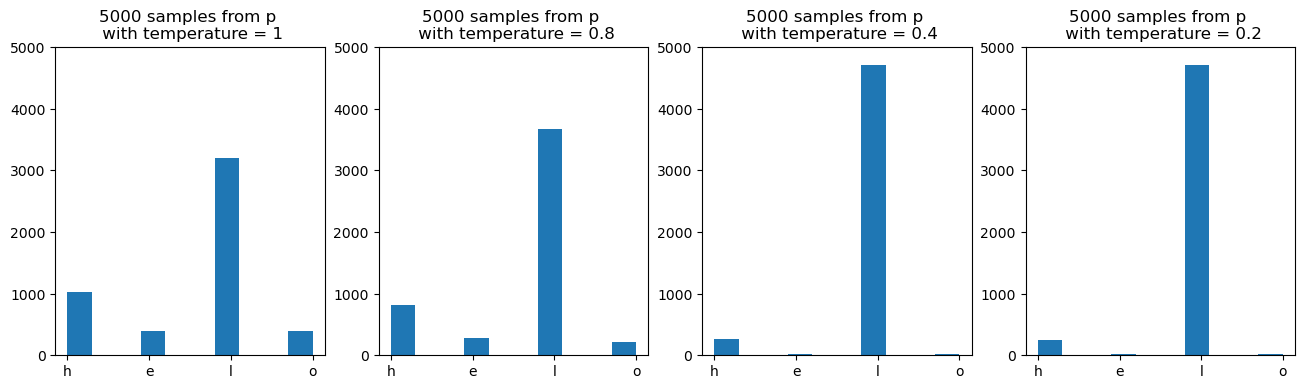

In [97]:
N = 5000
fig, axs = plt.subplots(1,4, figsize=[16,4])
temp1 = 1
axs[0].hist( [sample( p , temp1 ) for i in range(N)])
axs[0].set_title(f'{N} samples from p \n with temperature = {temp1}')
axs[0].set_xticks([0,1,2,3]); axs[0].set_xticklabels(['h','e','l','o'])
axs[0].set_ylim([0,5000])
temp2 = 0.8
axs[1].hist( [sample( p , temp2) for i in range(N)])
axs[1].set_title(f'{N} samples from p \n with temperature = {temp2}')
axs[1].set_xticks([0,1,2,3]); axs[1].set_xticklabels(['h','e','l','o'])
axs[1].set_ylim([0,5000]);
temp3 = 0.4
axs[2].hist( [sample( p , temp3) for i in range(N)])
axs[2].set_title(f'{N} samples from p \n with temperature = {temp3}')
axs[2].set_xticks([0,1,2,3]); axs[2].set_xticklabels(['h','e','l','o'])
axs[2].set_ylim([0,5000]);
temp4 = 0.2
axs[3].hist( [sample( p , temp3) for i in range(N)])
axs[3].set_title(f'{N} samples from p \n with temperature = {temp4}')
axs[3].set_xticks([0,1,2,3]); axs[3].set_xticklabels(['h','e','l','o'])
axs[3].set_ylim([0,5000]);

we basically explained this above but different temperature values affect the probability distribution output and with higher temperatures the output probabilites are closer together and with lower temperatures the differences expand making it more likely that the model will chose the predicted most likely character over chosing the 2nd or 3rd (or later) most highest probability character.

> **Ex. 5.1.4**: Did the network finish training? Consider the generated text across epochs.
1. In the early batches (0-10), the generated text looks very bad. Can you explain why the low temperature generated text contains almost only the symbol " " (that is, spaces)?
2. The high temperature generated text is strange too, but in a different way. Explain how.
3. Explain what developments you see, both in low- and high-temperature outputs, as training progresses.

1. The low temperature means that the model is almost guaranteed to chose the character with the highest probability. in this case, early on, the model is simply understanding that the most abundant character is the space ' ' and so that is basically always the highest probability for the next character and so it is predicting mostly spaces. however, as we can see above with the different temperature graphs (and with our hand calculated values), a higher temperature means the model is more likely to predict the 2nd or 3rd highest probability character since with high temp those characters have a higher probability. We can see this with the graphs above where at a high temp there is about a 20% chance to predict 'h' despite 'l' clearly being the model predicted output and with low temp 'h' is only about 4-5% likelyhood. This means that with higher temperature we more often get some random characters that are not spaces as we have seen with the early runs of the model. 
2. We basically explained this above as well, but with higher temperature, the model is more likely to chose a character that is not the highest probability character and right now in the early runs, that second or third highest character is very likely to be a random character as the model has not learned much and so we see mostly spaces corresponding to the highest probability but also a few random other characters that correspond to when the model chose a 2nd or 3rd or any other lower probability character. these are chosen much more frequently with the higher temp models due to the way temperature works which we explained above and you can see with the graphs where temp=1 graph has around a 30% chance to pick something that is not an 'l' whereas the temp=0.2 graph has about a 5% chance of picking something that is not 'l' 
3. As the model develops, the randomness in the higher temperature stays consistent with more weird letter combinations and less blank space overall. the higher temperature samples chose the less used characters like 'j' and capitals more often. the low temperature forms words that more closely resemble the training data words and puts together words in a structure that more resembles sentences as seen in the training data. This all makes sense due to low temperature's tendency to stick with the highest predicted output and high temperature's tendency to occasionally chose a less probable character. One clear example of this is the high temp runs often change the character headings and include random capital letters or non letters whereas the low temp runs almost never create a header that deviates from a true character name. 

> **Ex. 5.1.5**: For the network trained over all 100 epochs, generate a longer piece of text
(say 2000 symbols long). Use the sentence `text[1486:1526]` as seed (starts with 'YOUNG MAN' ends with 'No, ')
and set temperature to 0.5.
Describe what features of the screenplay and language the network learned in only 100 epochs (in general).
Also describe what mistakes it makes.
> 
> Save code and output below this cell.
>
> **Hint:** Reuse the code from the `on_epoch_end` function

In [82]:
sentence = text[1431:1471]
print(sentence)

YOUNG MAN
                         No, 


In [90]:
temperature = 0.5
print('----- temperature:', temperature)

generated = ''
sentence = text[1431:1471]
generated += sentence
print('----- Generating with seed: "' + sentence + '"')
sys.stdout.write(generated)

for i in range(400):
    x_pred = np.zeros((1, seqlen, len(chars)))
    for t, char in enumerate(sentence):
        x_pred[0, t, char_indices[char]] = 1. 

    preds = model.predict(x_pred, verbose=0)
    next_index = sample(preds[0, -1], temperature)
    next_char = indices_char[next_index]

    sentence = sentence[1:] + next_char

    sys.stdout.write(next_char)
    sys.stdout.flush()
print()

----- temperature: 0.5
----- Generating with seed: "YOUNG MAN
                         No, "
YOUNG MAN
                         No, no's gonna be gonna find.

                                               VINCENT
                         Maynard. I have to do. I'll have the finds ain't fuckin' get and his gun on the chanced. If has thin 
               the counter of and the black brought that gues the coffee. He's not the gun ard 
                         the shotgungucting his hill. And his apartment smiles.

       


Here we can see that the model has learned the basic structure of the script with capital letter headers on their own row and then a short section of text below with quick sentences and often curse words! It generally knows how to put together a sentence that at least looks like it makes sense at a glance and spells names correctly (for the most part, especially at a lower temp). 

It made mistakes about the sentence structure and which part of speech should go where. it also makes words that follow a very similar structure to words that it saw but that are not actual words where one or two letters are off. It can also make different mistakes on different runs, for example one time it lined up all the character names on the left but most of the time it middle aligns them as it is in the script. The number of clear mistakes it makes in writing understandable language increases with temperature increases. 

We do want to mention that we had to select a different index to get the right 40 character seed but we believe we chose the right part of the script. Either way, as we see below it barely matters that much!

> **Ex. 5.1.6**: Do the same as above, but for 40 random letters (e.g. smash away on your keyboard) as seed. What happens? Can you explain why? Save your character sequence and output.

In [98]:
temperature = 0.5
print('----- temperature:', temperature)

generated = ''
sentence = 'wacrovruxntyvwmqqofjjjlpoxrycctvttdffgdh'
print(len(sentence))
generated += sentence
print('----- Generating with seed: "' + sentence + '"')
sys.stdout.write(generated)

for i in range(400):
    x_pred = np.zeros((1, seqlen, len(chars)))
    for t, char in enumerate(sentence):
        x_pred[0, t, char_indices[char]] = 1. 

    preds = model.predict(x_pred, verbose=0)
    next_index = sample(preds[0, -1], temperature)
    next_char = indices_char[next_index]

    sentence = sentence[1:] + next_char

    sys.stdout.write(next_char)
    sys.stdout.flush()
print()

----- temperature: 0.5
40
----- Generating with seed: "wacrovruxntyvwmqqofjjjlpoxrycctvttdffgdh"
wacrovruxntyvwmqqofjjjlpoxrycctvttdffgdher the name.

                                     MAYNARD (n.A......Buncho down here the stands. 
                                           VINCENT
                              (to his wallet)
                         What?

                                          JULES
                         Well, done there toward his wallet, shot 
                         robbe!

             


Here we can see basically an identical output as we have previously had above with the seed from the movie. this happens because the model has only learned on the movie and has just learned to predict how the movie is styled and written. despite the seed not making any sense, the model still outputs text generated like the movie script is because that is all that it knows how to do and that is how it functionally selects the next character. it is not a gpt like model that would really respond to a prompt and sort of understand it, it just tries to continue it based on the patterns it picked up from the script. so, we can see that it just produces the jarbled script output as usual, just like it would if given an actual part of the script.